# Load Forecasting for the Air Handling System of an Office Building

This tutorial provides an example of forecasting hourly energy loads for a multi-zone [variable-air-volume (VAV)](https://en.wikipedia.org/wiki/Variable_air_volume) air handling system of an office building.

## Building HVAC System Load Forecasting
Forecasting energy loads for a building's [heating, ventilation, and air-conditioning (HVAC)](https://en.wikipedia.org/wiki/Heating,_ventilation,_and_air_conditioning) system involves predicting how much energy is required to heat, cool, and ventilate a building during a period of time, for example at an hourly level for one day.
Forecasting of building loads is useful for several applications, such as control optimization [1], management of [distributed energy resources](https://www.energy.ca.gov/data-reports/california-energy-planning-library/distributed-energy-resources) [2], and participating in [demand response](https://en.wikipedia.org/wiki/Demand_response) programs [3].
These loads are often forecasted based on historical data, forecasted weather, forecasted system control setpoints, and/or system operation statuses.

### Heating and Cooling Loads in Buildings

Heating and cooling loads in buildings can be estimated using an energy balance:

\begin{align}
\dot{Q}_{HVAC} = \dot{Q}_{internal}+\dot{Q}_{envelope}+\dot{Q}_{solar},
\end{align}

where $\dot{Q}_{HVAC}$ is the HVAC system load, $\dot{Q}_{internal}$ is the internal heat gains (e.g., heat from occupants, lighting, and electronics), $\dot{Q}_{envelope}$ is the heat transfer between the building interior and exterior through the [building envelope](https://en.wikipedia.org/wiki/Building_envelope), and $\dot{Q}_{solar}$ is the heat gained from sunlight through windows. Accordingly, the HVAC system load is dependent on disturbances such as the outdoor weather conditions and internal occupant behavior, as well as the building design and construction. Furthermore, the energy required for the HVAC system to meet the load is dependent on the performance of the HVAC system components (e.g., fans, compressors, and heaters).


<img src="figs/energy_balance.png"  width="1000"> 

### Building Load Forecasting References
[1] [Chengliang Fan and Yunfei Ding. Cooling load prediction and optimal operation of HVAC systems using a multiple nonlinear regression model. Energy and Buildings, Volume 197, pp. 7-17, 2019.](https://www.sciencedirect.com/science/article/pii/S0378778818337861.)    
[2] [Alessandro Beghi, Luca Cecchinato, Mirco Rampazzo, and Francesco Simmini. Load forecasting for the efficient energy management of HVAC systems. In 2010 IEEE International Conference on Sustainable Energy Technologies (ICSET), pp. 1-6. IEEE, 2010.](https://ieeexplore.ieee.org/abstract/document/5684414)  
[3] [Jonathan Schachter and Pierluigi Mancarella. A short-term load forecasting model for demand response applications. In 11th International Conference on the European Energy Market (EEM14), pp. 1-5. IEEE, 2014.](https://ieeexplore.ieee.org/abstract/document/6861220)  
[4] [Liang Zhang, Jin Wen, Yanfei Li, Jianli Chen, Yunyang Ye, Yangyang Fu, and William Livingood. A review of machine learning in building load prediction. Applied Energy, Volume 285, pp. 116452, 2021.](https://www.sciencedirect.com/science/article/abs/pii/S0306261921000209)    


## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install neuromancer

In [232]:
import torch
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import requests

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

torch.manual_seed(0)

## Import data

### System description

A schematic of the system used in this example is shown below. 
[This data is collected from a laboratory setup of a multi-zone VAV system of an office building.](https://www.nature.com/articles/s41597-022-01858-6)
The building has two floors with five zones on each floor. 
The [air handler](https://en.wikipedia.org/wiki/Air_handler) includes a roof top unit (RTU) with a heating and cooling coil and fan to condition and supply air to the zones.
Each zone includes a VAV terminal unit equipped with a [damper](https://en.wikipedia.org/wiki/Damper_(flow)) and reheat coil.
The temperature of each zone is controlled by individual thermostats and sensors/meters measuring temperature, humidity, airflow, electricity use, and gas use are included throughout the system.

<img src="figs/vav_schematic.jpg">  

### Data files

The data files used in this notebook can be found [here](https://figshare.com/articles/dataset/Scientific_Journal_Data_Empirical_HVAC_Operation/20520438/3).
The `Building_Base_Cooling.csv` file provides the system measurement data and the `Weather_Base_Cooling.csv` file provides the accompanying weather data for this experiment.


In [ ]:
# URL of the building measurements CSV file
url = "https://figshare.com/ndownloader/files/37624448"

# Download the file
response = requests.get(url)
with open("Building_Base_Cooling.csv", "wb") as file:
    file.write(response.content)

# Read the CSV file into a DataFrame
BaseCool = pd.read_csv("Building_Base_Cooling.csv")

# URL of the weather CSV file
url = "https://figshare.com/ndownloader/files/37624472"

# Download the file
response = requests.get(url)
with open("Weather_Base_Cooling.csv", "wb") as file:
    file.write(response.content)

# Read the CSV file into a DataFrame
WeatherCool = pd.read_csv("Weather_Base_Cooling.csv")

## Model application and feature and target data for model training

Depending on the application, building load forecast models require different input data. 
Models that are used purely for estimating loads for planning purposes (e.g., estimating peak loads or coordinating distributed energy resources) may use time/calendar features and forecasted weather data as inputs.
Alternatively, load forecasting models used for optimal control of HVAC systems may require control setpoint data as an input (e.g., thermostat or supply air temperature setpoints) in addition to other inputs such as forecasted weather.
There are other dynamics that can significantly impact building HVAC loads but can be difficult to control or predict (e.g., occupant behavior), so they are not typically used for load forecasting.

This notebook uses weather data, including outdoor air temperature and humidity, solar irradiance, and wind speed/direction, as features for training the load forecasting models.
The supply air temperature and the airflow rate measurement data at the RTU are also included and used as a proxy for control setpoints for the purposes of this notebook to emulate an application of load forecasting for developing optimal control policies.
Real systems might use forecasted supply air temperature and duct static pressure setpoints, for example, for load forecasting to develop optimal policies for those setpoints.
The target model output is the time series energy consumption of the RTU.

The reader is encouraged to test the model capability using different combinations of feature data, such as using only weather data without system measurements or adding new system measurements as features.

In [345]:
# Identify feature and target columns
sys_feat_columns = ['T_Sup_RTU', 'AF_RTU']
target_columns = ['WH_RTU_Total']
weather_excl_columns = ['TIMESTAMP'] # excludes timestamp but uses all other columns from weather data import

# Add data to numpy arrays
sys_feat = np.array(BaseCool[sys_feat_columns][1:]).astype(float)
targets = np.array(BaseCool[target_columns][1:]).astype(float)
weather = np.array(WeatherCool.drop(columns=weather_excl_columns)[1:]).astype(float)

# Combine weather and system features data
features = np.concatenate((sys_feat, weather), axis = 1) 

## Average minute level data for hourly predictions

This uses time-averaging to convert the minute level data to hourly level data. 
This may not be necessary for all applications, but an hourly time step for load predictions is more typical than a minute level time step.
Other time step sizes, such as 15 or 30 minute steps, can be tested by adjusting the `step_size` variable.

In [346]:
def moving_average(data, step_size):
    """
    Compute the moving average of the input data array using the specified step size.
    The moving average is calculated row-wise.
    
    Parameters:
    - data (numpy.ndarray): Input 2D data array.
    - step_size (int): Averaging step size.
    
    Returns:
    - numpy.ndarray: Array containing the moving average values.
    """
    # Initialize the result array with zeros
    num_rows, num_cols = data.shape
    new_rows = int(num_rows/step_size)
    averaged_data = np.zeros((new_rows, num_cols))
    
    # Compute the moving average row-wise
    for i in range(len(averaged_data)):
        averaged_data[i] = np.mean(data[i*step_size:i*step_size+step_size], axis=0)
    
    return averaged_data

# Average minute level data to create arrays of hourly data
step_size = 60 # in units of minutes (i.e., 60 minutes for an hour window size)
features_avg = moving_average(features, step_size)
targets_avg = moving_average(targets, step_size)
targets_avg = targets_avg*step_size/1000 # convert load data to kWh


## Plot hourly RTU load data
This shows the hourly RTU load data for a one week period during the cooling season. 
The load profile is characterized by peaks in the middle of the day when solar irradiance and the outdoor air temperature are high. 
Lower load values occur overnight as the sun sets and the outdoor air temperature cools.

Text(0, 0.5, 'RTU load (kWh)')

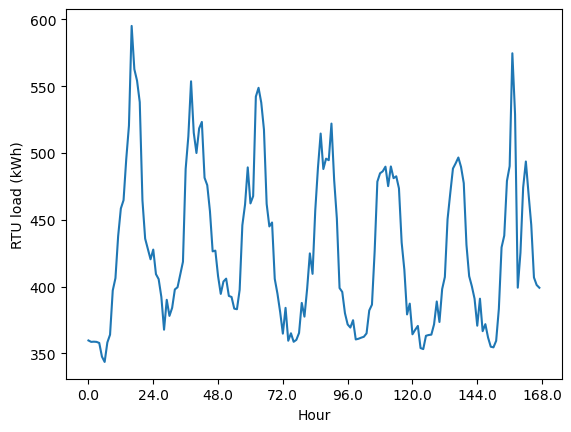

In [347]:
plt.plot(targets_avg)
plt.xticks(np.arange(0, len(targets_avg)+1, step=24*(60/step_size)), np.arange(0, (step_size/60)*len(targets_avg)+1, step=24))
plt.xlabel('Hour')
plt.ylabel('RTU load (kWh)')

## Normalize data
This normalizes the data based on the mean and standard deviation for each set of time series data points.
Normalization is useful for training these models especially when there are multiple inputs and outputs of different orders of magnitude (e.g., temperature, airflow rates, and power data of different orders of magnitude in this case).
The target mean and standard deviation are saved to variables for later plotting.

In [348]:
# Normalize features
for i in range(len(features_avg[0])):
    features_avg[:,i] = (features_avg[:,i]-np.mean(features_avg[:,i]))/np.std(features_avg[:,i])
    
# Normalize targets
targ_mean = np.mean(targets_avg)
targ_std = np.std(targets_avg)
targets_avg = (targets_avg-np.mean(targets_avg))/np.std(targets_avg)

## Data loading for model training

### Training and test data splits

This splits the dataset into data used to train the model and data used to test the trained model.
The first five days of the dataset are used for training and the last two days are used for testing.
The reader can change the `test_size` variable to experiment with the model's performance for different splits of training and test data.

### Dictionary datasets
The data is loaded into dictionary datasets by labeling the feature data as `X` and the target data as `Y`.
Loading the data in this method allows for symbolic representation of the different datasets (i.e., feature and target data) in this problem.
It also allows for a later visualization of how the different datasets are connected through the model.
Different titles other than `X` and `Y` can be used for the datasets, but the user should make sure they are assigned in a consistent manner throughout the model (e.g., `X` always refers to the feature data and `Y` always refers to the target data).

In [349]:
def get_splits(features, targets, bs, test_size=2/7):
    """
    :param features: (float) features array
    :param targets: (float) targets array
    :param bs: (int) batch size
    """
    features_train, features_test, targets_train, targets_test = train_test_split(features,
                                                                              targets,
                                                                              test_size = test_size,
                                                                              shuffle=False) 

    # Create features and targets tensors for train set
    featuresTrain = torch.from_numpy(features_train)
    targetsTrain = torch.from_numpy(targets_train)

    # Create features and targets tensors for test set
    featuresTest = torch.from_numpy(features_test)
    targetsTest = torch.from_numpy(targets_test)

    train_data, dev_data = [{"X": featuresTrain, "Y": targetsTrain}, {"X": featuresTest, "Y": targetsTest}]

    # Save test data array for plotting later
    test_data = dev_data

    # Load data into dictionary datasets and data loaders
    train_data = DictDataset(train_data, name="train")
    train_loader = DataLoader(train_data, batch_size=bs, collate_fn=train_data.collate_fn, shuffle=True)
    dev_data = DictDataset(dev_data, name="dev")
    dev_loader = DataLoader(dev_data, batch_size=bs, collate_fn=dev_data.collate_fn, shuffle=True)

    return train_loader, dev_loader, test_data


## Loading data into mini-batches

This step loads the data into [mini-batches](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/) to be used during the training and evaluation process.
The mini-batch size (`bs`) determines how many data points are used for each individual iteration during the model training before computing the loss and updating the model weights.
The reader can test the model performance by adjusting the `bs` parameter.
Generally, a smaller batch size can improve the model's ability to learn more specific pattens in the data, but can require more computation and lead to [over-fitting](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/).
Conversely, a larger batch size can speed up training and generalize broad trends in the data, but can lead to [under-fitting](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/).

In [350]:
# Define batch size and import data loaders
test_size = 2/7
bs = 10 # minibatching batch size
train_loader, dev_loader, dev_data = get_splits(features_avg, targets_avg, bs, test_size)

## Create MLP neural network model for load forecast prediction
First, a [multilayer perceptron (MLP)](https://en.wikipedia.org/wiki/Multilayer_perceptron) model is trained to perform the load forecasting.
The `input_size` and `output_size` are determined based on the number of inputs (features) and outputs (targets) for the model.
Different hyperparameters of this network can be adjusted, such as the hidden size.
Increasing the hidden size can improve the model accuracy, but can also increase computing time or result in over-fitting.
Too small of a hidden size can result in underfitting and poor prediction accuracy.
Other parts of the model can also be modified, such as the [non-linear activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6) (`nonlin`).
The MLP model is symbollically defined to take the features (`X`) as an input and output the predicted target load profile (`y`).


In [351]:
# define network architecture
input_size = len(features_avg[0]) 
output_size = len(targets_avg[0])
hidden_size = 40 # hidden size of MLP

# create MLP model
mlp = blocks.MLP(input_size, output_size, bias=True, linear_map=torch.nn.Linear, nonlin = torch.nn.ReLU, hsizes=[hidden_size,hidden_size])
modelMLP = mlp.to(torch.float64)
model_sym = Node(modelMLP, ['X'], ['y'], name='model')


## Define loss and constraints
Reference tracking loss is used for this problem, which compares the square of the difference between the model output and actual data for a given trajectory.
This case does not include any constraints, but possible constraints for load forecasting include enforcing values greater than zero (negative values do not have a physical meaning in this scenario) and maximum values less than the maxiumum capacity of the HVAC system (based on rated capacity of fans, compressors, reheat coils, etc.).

In [352]:
# define symbolic variables
y = variable("Y") # actual output
yhat = variable('y') # predicted output

# trajectory tracking loss
reference_loss = (yhat == y)^2
reference_loss.name = "ref_loss"

# objectives and constraints
objectives = [reference_loss]
constraints = []

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)

## Define optimizer and logger
The optimizer in this problem is defined using the [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) optimizer, but the user can explore the use of [other optimizers](https://pytorch.org/docs/stable/optim.html).
The learning rate (lr) in the optimizer can be adjusted based on the training performance for a specific problem.
Generally, a smaller learning rate can take more time to converge to an optimal solution, but can also improve the ability for the model to converge and avoid divergence during training.
The logger is created to output the training and development loss during training [epochs](https://www.geeksforgeeks.org/epoch-in-machine-learning/) and save log files to a `test` directory.

In [353]:
# create optimizer for model training
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=0.005)

# define logger
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])

None


## Define problem
For this problem, the only node comes from the load forecast model.
The problem is defined and visualized using the node and loss functions.
This shows that the model takes the features (`X`) as an input and outputs predicted targets (`y`), which are compared with the actual targets from the dataset (`Y`) to compuute the loss (`ref_loss`) and train the model.

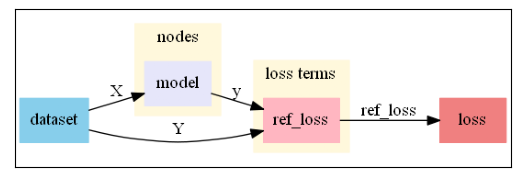

In [354]:
# define problem and show network
nodes = [model_sym]
problem = Problem(nodes,loss)
problem.show()

## Initialize Trainer
The trainer is defined based on the problem and training parameters.
Parameters such as the patience, warmup, and epochs determine minimum and maximum number of epochs for model training and can be tuned to improve the training performance.
This trainer is also re-used later in this notebook when the MLP model is replaced with other model architechtures. 

In [355]:
def getTrainer(problem, train_loader, dev_loader, optimizer, logger):

    trainer = Trainer(
        problem,
        train_loader,
        dev_loader,
        dev_loader,
        optimizer,
        patience=100,
        warmup=200,
        epochs=1000,
        eval_metric="dev_loss",
        train_metric="train_loss",
        dev_metric="dev_loss",
        test_metric="dev_loss",
        logger=logger,
    )

    return trainer

trainer = getTrainer(problem, train_loader, dev_loader, optimizer, logger)

Number of parameters: 2121


## Training Loop
This initializes the training process and saves the state of the best model based on the training.
The reader can view how the training loss and development loss evolve during the process.
The training loss should start at a higher value, then decrease over time before potentially oscillating near the optimal soluation.
The development loss is calculated using the development data, but is not used to train the model.
Thus, the development loss may exhibit behavior different than the training loss.

In [356]:
best_model_MLP = trainer.train()
problem.load_state_dict(best_model_MLP)

epoch: 0	train_loss: 0.11777	dev_loss: 0.34391	eltime:  8.36253
epoch: 1	train_loss: 0.14631	dev_loss: 0.07250	eltime:  8.36620
epoch: 2	train_loss: 0.09389	dev_loss: 0.05632	eltime:  8.39222
epoch: 3	train_loss: 0.04524	dev_loss: 0.01570	eltime:  8.40546
epoch: 4	train_loss: 0.01480	dev_loss: 0.23104	eltime:  8.41795
epoch: 5	train_loss: 0.03952	dev_loss: 0.17806	eltime:  8.43151
epoch: 6	train_loss: 0.06155	dev_loss: 0.14997	eltime:  8.44415
epoch: 7	train_loss: 0.02710	dev_loss: 0.08301	eltime:  8.44800
epoch: 8	train_loss: 0.03195	dev_loss: 0.03623	eltime:  8.46447
epoch: 9	train_loss: 0.02607	dev_loss: 0.18450	eltime:  8.48105
epoch: 10	train_loss: 0.00713	dev_loss: 0.01803	eltime:  8.48105
epoch: 11	train_loss: 0.02371	dev_loss: 0.41404	eltime:  8.50001
epoch: 12	train_loss: 0.03161	dev_loss: 0.05360	eltime:  8.51861
epoch: 13	train_loss: 0.00654	dev_loss: 0.08383	eltime:  8.53105
epoch: 14	train_loss: 0.02782	dev_loss: 0.30986	eltime:  8.54457
epoch: 15	train_loss: 0.06305	dev_l

<All keys matched successfully>

## Plot model outputs against test data
The predictions of the trained MLP model can be compared against the actual values from the test data.
Relevant metrics including mean square error (MSE) and mean absoluate error (MAE) are computed as well.
The results show the MLP model can capture the general trends of the load profile from the test data, but struggles to accurately predict the peak value on the second day.

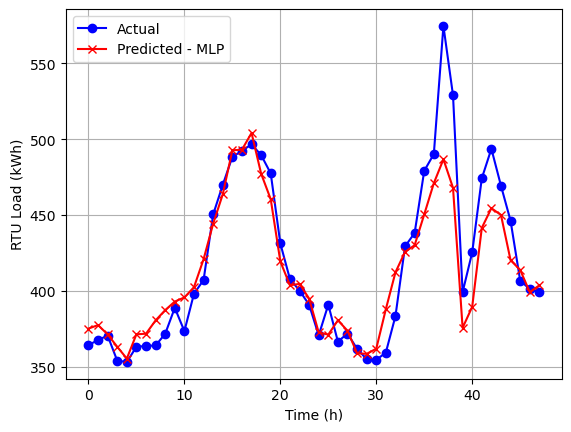

MSE and MAE: 480.23339563219446 14.826025115635062


In [357]:
# generate predictions on test data from MLP model
dev_data['name'] = 'test'
with torch.no_grad():
    test_outputs_MLP = problem(dev_data)

# get time steps and index where test data begins
time_steps = np.arange(len(test_outputs_MLP['test_y']))
div = int((1-test_size)*len(targets_avg))

# plot comparison
plt.plot(time_steps, targets_avg[div:]*targ_std+targ_mean, label='Actual', marker='o', color='blue')
plt.plot(time_steps, test_outputs_MLP['test_y']*targ_std+targ_mean, label='Predicted - MLP', marker='x', color='red')
plt.xlabel('Time (h)')
plt.ylabel('RTU Load (kWh)')
plt.legend()
plt.grid(True)
plt.show()

# compute mean square error and mean absolute error metrics
print('MSE and MAE:', np.mean((targets_avg[div:]*targ_std-np.array(test_outputs_MLP['test_y']*targ_std))**2), \
                                np.mean((np.abs(targets_avg[div:]*targ_std-np.array(test_outputs_MLP['test_y']*targ_std)))))


## Repeat training process with RNN model

Next, the MLP model is replaced with a [recurrent neural network (RNN)](https://en.wikipedia.org/wiki/Recurrent_neural_network) model and the training process is repeated.
RNN models are often used for time series predictions like this load forecasting example.
The same loss function is used and the same training and test data is reloaded.
The nodes, problem, and optimizer need to be re-defined for the new model and loaded into the trainer using the `getTrainer` function from before.

In [358]:
# define model and training parameters
hidden_size = 40
rnn = blocks.RNN(input_size, output_size, bias=True, linear_map=torch.nn.Linear, nonlin = torch.nn.ReLU, hsizes=[hidden_size,hidden_size])
modelRNN = rnn.to(torch.float64)

# create nodes and problem for training RNN model
model_sym_RNN = Node(modelRNN, ['X'], ['y'], name='model')
nodesRNN = [model_sym_RNN]
problemRNN = Problem(nodesRNN,loss)
optimizerRNN = torch.optim.Adam(modelRNN.parameters(), lr=0.005)

# reload data
train_loader, dev_loader, dev_data = get_splits(features_avg, targets_avg, bs)
trainerRNN = getTrainer(problemRNN, train_loader, dev_loader, optimizerRNN, logger)


Number of parameters: 5481


## Initialize training loop for RNN model
The training process is then repeated for the RNN model and the best model is saved.
The reader can compare the training and development loss for the RNN model vs the MLP model.

In [359]:
best_model_RNN = trainerRNN.train()
problemRNN.load_state_dict(best_model_RNN)

epoch: 0	train_loss: 0.22176	dev_loss: 0.23865	eltime:  63.36337
epoch: 1	train_loss: 0.12477	dev_loss: 0.11525	eltime:  63.38695
epoch: 2	train_loss: 0.03567	dev_loss: 0.04467	eltime:  63.40827
epoch: 3	train_loss: 0.06197	dev_loss: 0.19506	eltime:  63.42421
epoch: 4	train_loss: 0.02711	dev_loss: 0.04795	eltime:  63.44362
epoch: 5	train_loss: 0.02534	dev_loss: 0.36078	eltime:  63.46826
epoch: 6	train_loss: 0.00518	dev_loss: 0.15818	eltime:  63.48508
epoch: 7	train_loss: 0.07145	dev_loss: 0.11676	eltime:  63.50413
epoch: 8	train_loss: 0.03192	dev_loss: 0.04151	eltime:  63.51960
epoch: 9	train_loss: 0.00267	dev_loss: 0.02008	eltime:  63.54548
epoch: 10	train_loss: 0.02989	dev_loss: 0.02139	eltime:  63.56007
epoch: 11	train_loss: 0.08581	dev_loss: 0.50966	eltime:  63.58408
epoch: 12	train_loss: 0.10110	dev_loss: 0.51017	eltime:  63.60283
epoch: 13	train_loss: 0.01833	dev_loss: 0.12744	eltime:  63.61855
epoch: 14	train_loss: 0.07297	dev_loss: 0.26949	eltime:  63.63409
epoch: 15	train_loss

<All keys matched successfully>

## Plot comparison of MLP and RNN predictions against test data
The predictions of the trained RNN model are compared against the actual values from the test data as well as the predictions from the MLP model.
The results show the RNN model performs similarly to the MLP model and also struggles to capture the peak load value on the second day.
The MSE and MAE results slightly favor the RNN model, but not significantly.

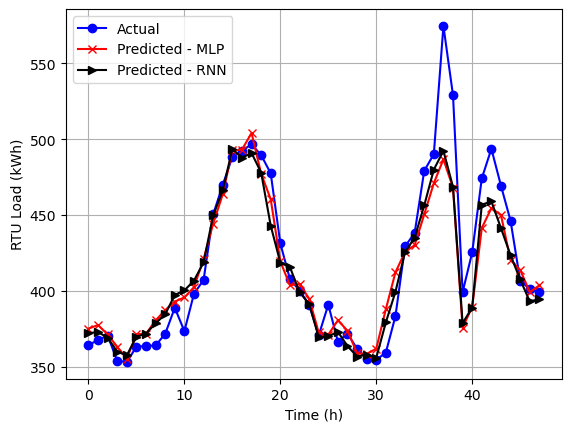

MSE and MAE (MLP): 480.23339563219446 14.826025115635062
MSE and MAE (RNN): 420.95199640714526 13.501880412150951


In [360]:
# generate predictions on test data from RNN model
dev_data['name'] = 'test'
with torch.no_grad():
    test_outputs_RNN = problemRNN(dev_data)

# plot comparison
plt.plot(time_steps, targets_avg[div:]*targ_std+targ_mean, label='Actual', marker='o', color='blue')
plt.plot(time_steps, test_outputs_MLP['test_y']*targ_std+targ_mean, label='Predicted - MLP', marker='x', color='red')
plt.plot(time_steps, test_outputs_RNN['test_y']*targ_std+targ_mean, label='Predicted - RNN', marker='>', color='black')
plt.xlabel('Time (h)')
plt.ylabel('RTU Load (kWh)')
plt.legend()
plt.grid(True)
plt.show()

# compute mean square error and mean absolute error metrics
print('MSE and MAE (MLP):', np.mean((targets_avg[div:]*targ_std-np.array(test_outputs_MLP['test_y']*targ_std))**2), \
                                np.mean((np.abs(targets_avg[div:]*targ_std-np.array(test_outputs_MLP['test_y']*targ_std)))))
print('MSE and MAE (RNN):', np.mean((targets_avg[div:]*targ_std-np.array(test_outputs_RNN['test_y']*targ_std))**2), \
                                np.mean((np.abs(targets_avg[div:]*targ_std-np.array(test_outputs_RNN['test_y']*targ_std)))))

## Repeat training process with CNN model

Lastly, the a [convolutional neural network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) model is used for the load forecasting and the training process is repeated.
CNN models are often used for processing spatial data (like images), but have also been used for time series predictions.
The CNN architecture is defined using PyTorch but Neuromancer is used to re-define the nodes, problem, optimizer, and re-create the trainer.
The data also needs to be reloaded.

None


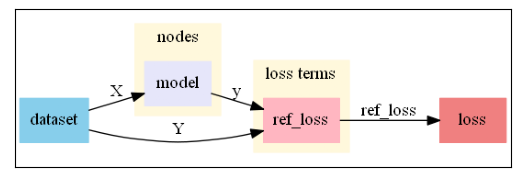

Number of parameters: 2049


In [368]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, input_size, output_size, out_channels=64):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv1d(input_size, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channels, output_size)

    def forward(self, x):
        # x should have shape (batch_size, input_size, length)
        x=x.transpose(0,1)
        # Pass through the first conv layer and ReLU
        x = self.conv1(x)
        x = self.relu(x)
        x=x.transpose(0,1)
        
        # Pass through the linear layer
        x = self.linear(x)
        
        # Output will have shape (batch_size, output_size, length)
        return x

# Define model and training parameters
cnn = CNN(input_size, output_size)
modelCNN = cnn.to(torch.float64)
model_sym_CNN = Node(modelCNN, ['X'], ['y'], name='model')
optimizerCNN = torch.optim.Adam(modelCNN.parameters(), lr=0.005)

loggerCNN = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])

nodes = [model_sym_CNN]
problemCNN = Problem(nodes,loss)
problemCNN.show()

# Reload data
train_loader, dev_loader, dev_data = get_splits(features_avg, targets_avg, bs)
trainerCNN = getTrainer(problemCNN, train_loader, dev_loader, optimizerCNN, logger)

## Initialize training loop for CNN model
The training process is then repeated for the CNN model and the best model is saved.
The reader can compare the training and development loss for the CNN model with the previous models.

In [369]:
best_model_CNN = trainerCNN.train()
problemCNN.load_state_dict(best_model_CNN)

epoch: 0	train_loss: 0.19165	dev_loss: 0.41128	eltime:  240.03815
epoch: 1	train_loss: 0.19924	dev_loss: 0.20158	eltime:  240.06928
epoch: 2	train_loss: 0.11799	dev_loss: 0.35988	eltime:  240.09155
epoch: 3	train_loss: 0.05131	dev_loss: 0.08202	eltime:  240.11895
epoch: 4	train_loss: 0.04783	dev_loss: 0.09997	eltime:  240.15276
epoch: 5	train_loss: 0.07710	dev_loss: 0.12984	eltime:  240.17891
epoch: 6	train_loss: 0.11759	dev_loss: 0.18473	eltime:  240.19926
epoch: 7	train_loss: 0.01688	dev_loss: 0.07927	eltime:  240.22023
epoch: 8	train_loss: 0.02826	dev_loss: 0.08072	eltime:  240.23532
epoch: 9	train_loss: 0.10277	dev_loss: 0.43837	eltime:  240.26023
epoch: 10	train_loss: 0.07101	dev_loss: 0.06470	eltime:  240.27207
epoch: 11	train_loss: 0.08049	dev_loss: 0.01773	eltime:  240.30902
epoch: 12	train_loss: 0.04507	dev_loss: 0.09427	eltime:  240.31856
epoch: 13	train_loss: 0.02939	dev_loss: 0.44566	eltime:  240.35245
epoch: 14	train_loss: 0.05027	dev_loss: 0.08135	eltime:  240.37604
epoch

<All keys matched successfully>

## Plot comparison of all three models against test data
The predictions of the trained CNN model are compared against the actual values from the test data as well as the predictions from the MLP and RNN models.
The results show the CNN model performs the worst of the three, particularly because it struggles to accurately predict the load values as the rise during the morning on the first day.
The reader is encouraged to try and improve the performance of this model by changing the CNN architecture or tuning hyperparmeters (e.g., learning rate) for the training process.

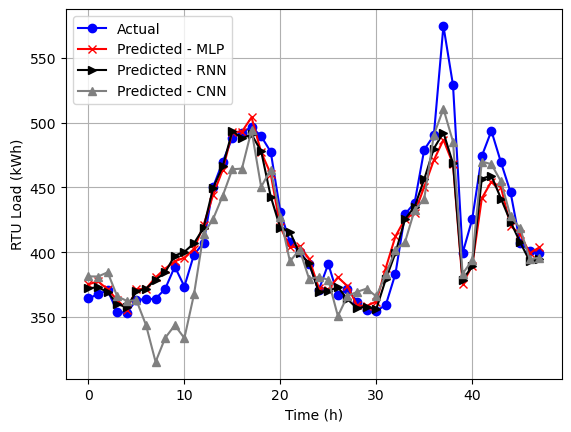

MSE and MAE (MLP): 480.23339563219446 14.826025115635062
MSE and MAE (RNN): 420.95199640714526 13.501880412150951
MSE and MAE (CNN): 563.1150115326392 19.02875063777603


In [366]:
# generate predictions on test data from RNN model
dev_data['name'] = 'test'
with torch.no_grad():
    test_outputs_CNN = problemCNN(dev_data)

# plot comparison
plt.plot(time_steps, targets_avg[div:]*targ_std+targ_mean, label='Actual', marker='o', color='blue')
plt.plot(time_steps, test_outputs_MLP['test_y']*targ_std+targ_mean, label='Predicted - MLP', marker='x', color='red')
plt.plot(time_steps, test_outputs_RNN['test_y']*targ_std+targ_mean, label='Predicted - RNN', marker='>', color='black')
plt.plot(time_steps, test_outputs_CNN['test_y']*targ_std+targ_mean, label='Predicted - CNN', marker='^', color='gray')
plt.xlabel('Time (h)')
plt.ylabel('RTU Load (kWh)')
plt.legend()
plt.grid(True)
plt.show()

# compute mean square error and mean absolute error metrics
print('MSE and MAE (MLP):', np.mean((targets_avg[div:]*targ_std-np.array(test_outputs_MLP['test_y']*targ_std))**2), \
                                np.mean((np.abs(targets_avg[div:]*targ_std-np.array(test_outputs_MLP['test_y']*targ_std)))))
print('MSE and MAE (RNN):', np.mean((targets_avg[div:]*targ_std-np.array(test_outputs_RNN['test_y']*targ_std))**2), \
                                np.mean((np.abs(targets_avg[div:]*targ_std-np.array(test_outputs_RNN['test_y']*targ_std)))))
print('MSE and MAE (CNN):', np.mean((targets_avg[div:]*targ_std-np.array(test_outputs_CNN['test_y']*targ_std))**2), \
                                np.mean((np.abs(targets_avg[div:]*targ_std-np.array(test_outputs_CNN['test_y']*targ_std)))))